<a href="https://colab.research.google.com/github/Dewdiii/Forecasting-Industry-Growth-Based-on-Historical-Trade-Data-Exports-Imports-in-Sri-Lanka./blob/main/ImpExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, pickle
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import files
uploaded = files.upload()  # Choose ImpExp.zip

Saving ImpExp.zip to ImpExp.zip


In [3]:
import zipfile
import os

with zipfile.ZipFile("ImpExp.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")  # extracts to data/ImpExp/

In [4]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

## Build the Dataset

In [5]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_industry_data(industry):
    # List all .xlsx files inside the industry-specific folder
    all_csvs = os.listdir(data_dir.format(industry))
    all_csvs = [f for f in all_csvs if f.endswith(".xlsx")]
    all_csv_paths = [os.path.join(data_dir.format(industry), f) for f in all_csvs]

    all_data = []
    for csv in all_csv_paths:
        df = pd.read_excel(csv, sheet_name='Partner')
        df['Partner Name'] = df['Partner Name'].str.strip()
        df = df[df['Partner Name'] == 'World']
        assert len(df) == 1, f"More than one or no 'World' data found in {csv}"

        df = df[[
            'Year',
            'Export (US$ Thousand)',
            'Import (US$ Thousand)',
            'Revealed comparative advantage',
            'World Growth (%)',
            'Country Growth (%)',
            'AHS Simple Average (%)',
            'AHS Dutiable Tariff Lines Share (%)',
        ]]
        df.reset_index(drop=True, inplace=True)
        all_data.append(df)

    # Combine all files
    all_data = pd.concat(all_data).reset_index(drop=True)

    # Fill missing values with column means
    all_data.fillna(all_data.mean(), inplace=True)
    all_data = all_data.astype(float)

    # Sort by year and remove the 'Year' column
    all_data.sort_values(by='Year', inplace=True)
    all_data.drop(columns=['Year'], inplace=True)

    # Fit and save the scaler
    scaler = StandardScaler()
    scaler.fit(all_data)

    # Create model directory if it doesn't exist
    os.makedirs(os.path.dirname(model_dir.format("")), exist_ok=True)

    with open(model_dir.format(f"{industry} Scalar.pickle"), 'wb') as f:
        pickle.dump(scaler, f)

    # Scale the data
    scaled_data = pd.DataFrame(scaler.transform(all_data), columns=all_data.columns)
    return scaled_data

def make_ts_dataset(industry, selective_window=7):
    df = load_industry_data(industry)

    X, Y1, Y2 = [], [], []
    for i in range(len(df) - selective_window):
        x = df.iloc[i:i+selective_window].values
        y1 = df.iloc[i+selective_window, 0]  # Export
        y2 = df.iloc[i+selective_window, 1]  # Import

        X.append(x)
        Y1.append(y1)
        Y2.append(y2)

    return np.array(X), np.array(Y1), np.array(Y2)


### Load Sample Data

In [6]:
X, Y1, Y2 = make_ts_dataset('Agricultural Raw Materials')

print("World Data Shape : ", X.shape)
print("Export Data Shape : ", Y1.shape)
print("Import Data Shape : ", Y2.shape)

World Data Shape :  (9, 7, 7)
Export Data Shape :  (9,)
Import Data Shape :  (9,)


**Splitting dataset**

In [7]:
def train_test_split_ts(X, Y1, Y2, train_ratio=0.8):
    split_index = int(len(X) * train_ratio)
    return X[:split_index], X[split_index:], Y1[:split_index], Y1[split_index:], Y2[:split_index], Y2[split_index:]

# Use the functions
X, Y1, Y2 = make_ts_dataset("Agricultural Raw Materials", selective_window=7)
X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split_ts(X, Y1, Y2)

## Build, Train, Evaluate model

**Baseline model**

**ARIMA**

In [55]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def train_arima_model(train, test, title='', plot=False):
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()

    predictions = model_fit.forecast(steps=len(test))

    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)

    print(title + " - ARIMA MSE: %.4f" % mse)
    print(title + " - ARIMA MAE: %.4f" % mae)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(range(len(train)), train, label='Train')
        plt.plot(range(len(train), len(train) + len(test)), test, label='Test', color='orange')
        plt.plot(range(len(train), len(train) + len(test)), predictions, label='ARIMA Predictions', color='green')
        plt.title(title + ' - ARIMA Forecast')
        plt.legend()
        plt.show()

    return mse, mae

In [56]:
def run_arima_model(industry):
    _, Y1, Y2 = make_ts_dataset(industry)

    # Flatten because ARIMA needs 1D
    Y1 = Y1.flatten()
    Y2 = Y2.flatten()

    # Simple 80/20 split
    split_idx = int(len(Y1) * 0.8)
    Y1_train, Y1_test = Y1[:split_idx], Y1[split_idx:]
    Y2_train, Y2_test = Y2[:split_idx], Y2[split_idx:]

    imp_mse, imp_mae = train_arima_model(Y2_train, Y2_test, title=f'{industry} Import')
    exp_mse, exp_mae = train_arima_model(Y1_train, Y1_test, title=f'{industry} Export')

    return {
        "Imp_MSE": imp_mse,
        "Imp_MAE": imp_mae,
        "Exp_MSE": exp_mse,
        "Exp_MAE": exp_mae
    }

In [58]:
results_arima = run_arima_model("Agricultural Raw Materials")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Agricultural Raw Materials Import - ARIMA MSE: 2.3144
Agricultural Raw Materials Import - ARIMA MAE: 1.5085
Agricultural Raw Materials Export - ARIMA MSE: 0.2558
Agricultural Raw Materials Export - ARIMA MAE: 0.4994


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
results_arima = run_arima_model("Consumer Goods")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Consumer Goods Import - ARIMA MSE: 0.2107
Consumer Goods Import - ARIMA MAE: 0.3792
Consumer Goods Export - ARIMA MSE: 0.2559
Consumer Goods Export - ARIMA MAE: 0.4986


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
results_arima = run_arima_model("Transportation")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Transportation Import - ARIMA MSE: 1.7048
Transportation Import - ARIMA MAE: 1.1533
Transportation Export - ARIMA MSE: 1.5955
Transportation Export - ARIMA MAE: 0.9755


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [61]:
results_arima = run_arima_model("Food Industry")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Food Industry Import - ARIMA MSE: 0.2079
Food Industry Import - ARIMA MAE: 0.4417
Food Industry Export - ARIMA MSE: 0.0754
Food Industry Export - ARIMA MAE: 0.2665


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
results_arima = run_arima_model("Capital Goods")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Capital Goods Import - ARIMA MSE: 0.6969
Capital Goods Import - ARIMA MAE: 0.7041
Capital Goods Export - ARIMA MSE: 0.9875
Capital Goods Export - ARIMA MAE: 0.9430


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Advanced Models**

**LSTM**

In [51]:
def build_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae']
    )
    return model

def train_lstm_model(industry, epochs=100, batch_size=4):
    X, Y1, Y2 = make_ts_dataset(industry)

    X_train, X_test, Y1_train, Y1_test, Y2_train, Y2_test = train_test_split_ts(X, Y1, Y2)

    print(f"................ Training LSTM on : {industry} ................")

    model_exp = build_lstm_model()
    model_imp = build_lstm_model()

    history_exp = model_exp.fit(
        X_train,
        Y1_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y1_test)
    )

    history_imp = model_imp.fit(
        X_train,
        Y2_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y2_test)
    )

    model_exp.save(model_dir.format(f"{industry} LSTM_Exp.h5"))
    model_imp.save(model_dir.format(f"{industry} LSTM_Imp.h5"))

    return model_exp, model_imp, history_exp, history_imp

In [52]:
def evaluate_lstm(model, X_test, Y_test, label=""):
    preds = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(Y_test, preds))
    mae = mean_absolute_error(Y_test, preds)
    print(f"{label} - LSTM RMSE: {rmse:.4f}")
    print(f"{label} - LSTM MAE: {mae:.4f}")
    return rmse, mae

In [53]:
def run_lstm_model(industry):
    imp_loss, imp_mae, exp_loss, exp_mae = train_lstm_model(industry)
    return {
        "Imp_MSE": imp_loss,
        "Imp_MAE": imp_mae,
        "Exp_MSE": exp_loss,
        "Exp_MAE": exp_mae
    }

In [65]:
# Train model
model_exp, model_imp, history_exp, history_imp = train_lstm_model('Agricultural Raw Materials')

# Evaluate
evaluate_lstm(model_exp, X_test, Y1_test, "Export")
evaluate_lstm(model_imp, X_test, Y2_test, "Import")

................ Training LSTM on: Agricultural Raw Materials ................


ValueError: not enough values to unpack (expected 7, got 4)

In [ ]:
# Train model
model_exp, model_imp, history_exp, history_imp = train_lstm_model('Consumer Goods')

# Evaluate
evaluate_lstm(model_exp, X_test, Y1_test, "Export")
evaluate_lstm(model_imp, X_test, Y2_test, "Import")

In [ ]:
# Train model
model_exp, model_imp, history_exp, history_imp = train_lstm_model('Transportation')

# Evaluate
evaluate_lstm(model_exp, X_test, Y1_test, "Export")
evaluate_lstm(model_imp, X_test, Y2_test, "Import")

In [ ]:
# Train model
model_exp, model_imp, history_exp, history_imp = train_lstm_model('Food Industry')

# Evaluate
evaluate_lstm(model_exp, X_test, Y1_test, "Export")
evaluate_lstm(model_imp, X_test, Y2_test, "Import")

In [ ]:
# Train model
model_exp, model_imp, history_exp, history_imp = train_lstm_model('Capital Goods')

# Evaluate
evaluate_lstm(model_exp, X_test, Y1_test, "Export")
evaluate_lstm(model_imp, X_test, Y2_test, "Import")

**GRU**

In [45]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

def build_ts_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae']
    )
    return model

def train_ts_model(industry, epochs=100, batch_size=4):
    X, Y1, Y2 = make_ts_dataset(industry)

    # Split dataset 80% train, 20% test (same split for Y1 and Y2)
    X_train, X_test, Y1_train, Y1_test = train_test_split(X, Y1, test_size=0.2, random_state=42)
    _, _, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=42)

    print(f"................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    history_imp = model_imp.fit(
        X_train, Y1_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y1_test)
    )

    history_exp = model_exp.fit(
        X_train, Y2_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, Y2_test)
    )

    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    # Evaluate on test set
    imp_test_loss, imp_test_mae = model_imp.evaluate(X_test, Y1_test, verbose=0)
    exp_test_loss, exp_test_mae = model_exp.evaluate(X_test, Y2_test, verbose=0)
    print(f"Import Model Test MAE: {imp_test_mae:.4f}")
    print(f"Export Model Test MAE: {exp_test_mae:.4f}")

    return history_imp, history_exp

def plot_loss(industry, history_imp, history_exp):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='Train Loss (MSE)')
    plt.plot(history_imp.history['val_loss'], label='Val Loss (MSE)')
    plt.plot(history_imp.history['mae'], label='Train MAE')
    plt.plot(history_imp.history['val_mae'], label='Val MAE')
    plt.title(f"Import Model Loss & MAE")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='Train Loss (MSE)')
    plt.plot(history_exp.history['val_loss'], label='Val Loss (MSE)')
    plt.plot(history_exp.history['mae'], label='Train MAE')
    plt.plot(history_exp.history['val_mae'], label='Val MAE')
    plt.title(f"Export Model Loss & MAE")
    plt.legend()

    plt.suptitle(f"{industry} Model Training & Validation Metrics")
    plt.show()

def run_gru_model(industry):
    imp_loss, imp_mae, exp_loss, exp_mae = train_ts_model(industry)
    return {
        "Imp_MSE": imp_loss,
        "Imp_MAE": imp_mae,
        "Exp_MSE": exp_loss,
        "Exp_MAE": exp_mae
    }

def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)

................ Training on : Agricultural Raw Materials ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 888ms/step - loss: 0.3080 - mae: 0.3695 - val_loss: 0.2603 - val_mae: 0.3942
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.4192 - mae: 0.5247 - val_loss: 0.0744 - val_mae: 0.2296
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2477 - mae: 0.4346 - val_loss: 0.0469 - val_mae: 0.2143
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1666 - mae: 0.3691 - val_loss: 0.0915 - val_mae: 0.2970
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1318 - mae: 0.3298 - val_loss: 0.1794 - val_mae: 0.4037
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0851 - mae: 0.2336 - val_loss: 0.2305 - val_mae: 0.4385
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0704 - mae: 0.2343 - val_loss: 0.2498 - val_mae: 0.4307
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0643 - mae: 0.2308 - val_loss: 0.1985 - val_mae:

Import Model Test MAE: 0.6615
Export Model Test MAE: 0.3347


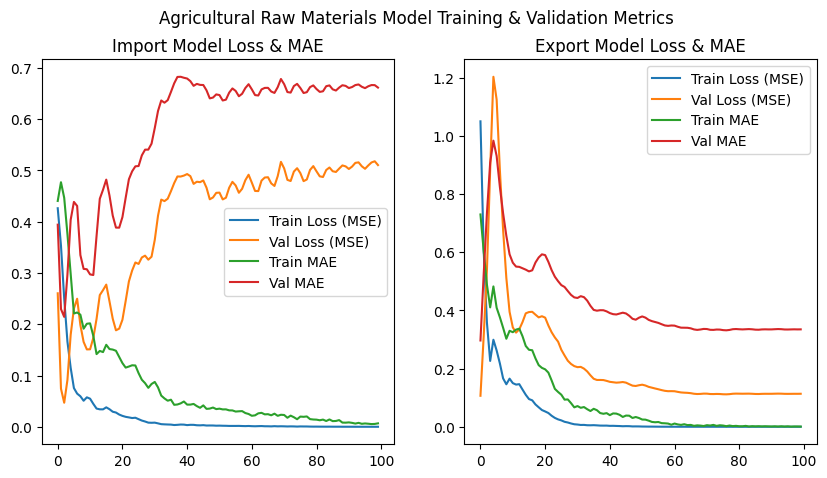

In [46]:
run_ts_model("Agricultural Raw Materials")

................ Training on : Consumer Goods ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 856ms/step - loss: 0.6954 - mae: 0.7234 - val_loss: 0.1073 - val_mae: 0.2802
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.4580 - mae: 0.6025 - val_loss: 0.2713 - val_mae: 0.5149
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1705 - mae: 0.3202 - val_loss: 0.4515 - val_mae: 0.6596
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.1203 - mae: 0.2508 - val_loss: 0.6061 - val_mae: 0.7129
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1282 - mae: 0.3297 - val_loss: 0.5716 - val_mae: 0.6166
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0795 - mae: 0.2466 - val_loss: 0.4550 - val_mae: 0.4797
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0588 - mae: 0.1837 - val_loss: 0.3542 - val_mae: 0.4783
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0412 - mae: 0.1799 - val_loss: 0.3070 - val_mae: 0.4731
Ep

Import Model Test MAE: 0.4775
Export Model Test MAE: 0.4862


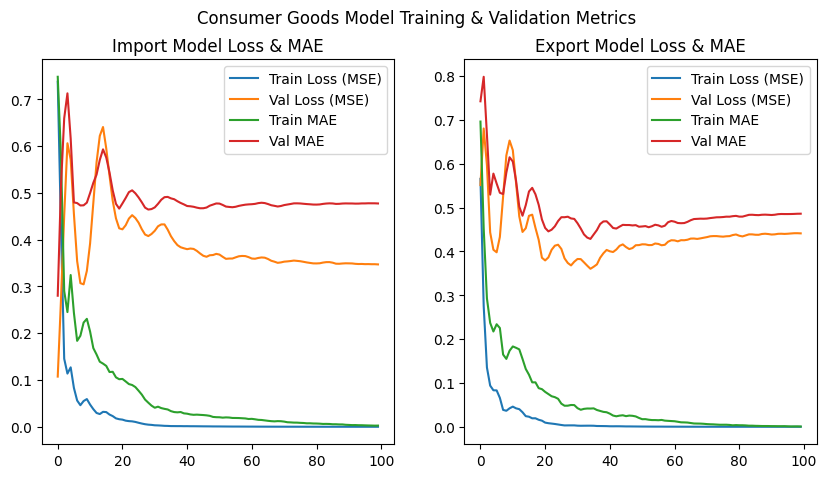

In [47]:
run_ts_model("Consumer Goods")

................ Training on : Transportation ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - loss: 1.2398 - mae: 0.6818 - val_loss: 0.5438 - val_mae: 0.7366
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 1.4503 - mae: 0.8259 - val_loss: 0.8609 - val_mae: 0.8959
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.7600 - mae: 0.6731 - val_loss: 1.0970 - val_mae: 1.0046
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.9652 - mae: 0.8085 - val_loss: 1.3210 - val_mae: 1.1034
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.9458 - mae: 0.8668 - val_loss: 1.2954 - val_mae: 1.1211
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.7743 - mae: 0.7246 - val_loss: 1.2624 - val_mae: 1.1212
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.7621 - mae: 0.6932 - val_loss: 1.2008 - val_mae: 1.0943
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.7335 - mae: 0.7099 - val_loss: 1.1254 - val_mae: 1.0476
Epoch 

Import Model Test MAE: 0.4341
Export Model Test MAE: 0.2342


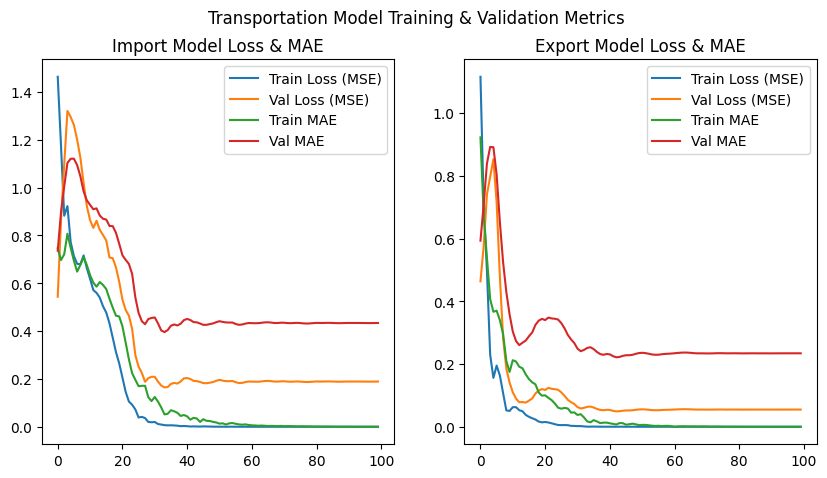

In [48]:
run_ts_model("Transportation")

................ Training on : Food Industry ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step - loss: 0.7638 - mae: 0.6163 - val_loss: 0.2442 - val_mae: 0.3972
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.6817 - mae: 0.6270 - val_loss: 0.0167 - val_mae: 0.1031
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2924 - mae: 0.4082 - val_loss: 0.0547 - val_mae: 0.2175
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1600 - mae: 0.2978 - val_loss: 0.2722 - val_mae: 0.4619
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1919 - mae: 0.3403 - val_loss: 0.3581 - val_mae: 0.4864
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1297 - mae: 0.2757 - val_loss: 0.3239 - val_mae: 0.4414
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1085 - mae: 0.2505 - val_loss: 0.2349 - val_mae: 0.3507
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0826 - mae: 0.2309 - val_loss: 0.1660 - val_mae: 0.3190
Epoch 9/1

Import Model Test MAE: 0.4067
Export Model Test MAE: 0.3289


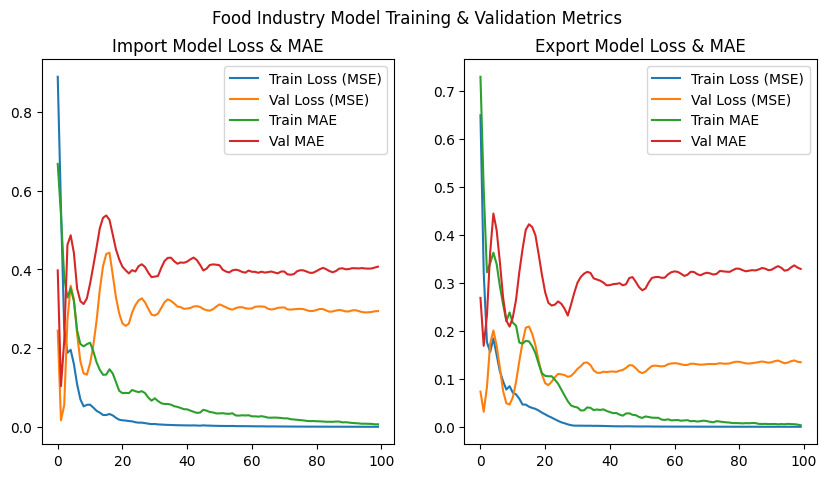

In [49]:
run_ts_model("Food Industry")

................ Training on : Capital Goods ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 686ms/step - loss: 1.1838 - mae: 0.9217 - val_loss: 0.0183 - val_mae: 0.1319
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.4430 - mae: 0.5999 - val_loss: 0.1787 - val_mae: 0.3702
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3856 - mae: 0.5032 - val_loss: 0.5573 - val_mae: 0.6159
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.3082 - mae: 0.4847 - val_loss: 0.9424 - val_mae: 0.8322
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2906 - mae: 0.4525 - val_loss: 1.0334 - val_mae: 0.9481
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2578 - mae: 0.4144 - val_loss: 1.0084 - val_mae: 0.9905
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2579 - mae: 0.4170 - val_loss: 0.9498 - val_mae: 0.9744
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2458 - mae: 0.4211 - val_loss: 0.8793 - val_mae: 0.9356
Epoch 9/1

Import Model Test MAE: 0.3690
Export Model Test MAE: 0.4391


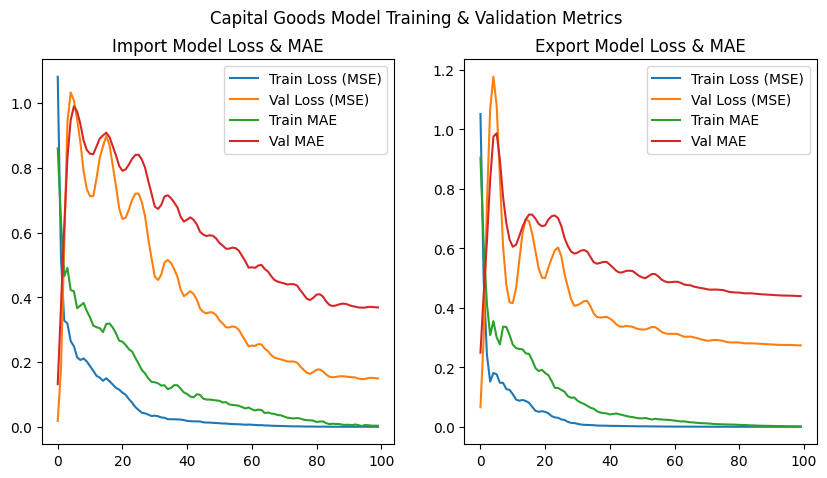

In [50]:
run_ts_model("Capital Goods")

**Model Comparison**

In [44]:
import pandas as pd

# Define industries
industries = [
    'Agricultural Raw Materials',
    'Consumer Goods',
    'Transportation',
    'Food Industry',
    'Capital Goods'
]

# Initialize results list
results = []

# Dummy functions: replace with your actual implementations
def run_arima(industry):
    # returns mae
    mae = 0.15  # Replace with real ARIMA logic
    return mae

def run_lstm(industry):
    # returns mae
    _, mae = train_lstm_model(industry)  # returns (history, mae)
    return mae

def run_gru(industry):
    # returns mae
    _, mae = train_gru_model(industry)  # returns (history, mae)
    return mae

# Loop through each industry and run all 3 models
for industry in industries:
    print(f"\nRunning models for {industry}...")

    arima_mae = run_arima(industry)
    lstm_mae = run_lstm(industry)
    gru_mae = run_gru(industry)

    results.append({
        "Industry": industry,
        "ARIMA MAE": arima_mae,
        "LSTM MAE": lstm_mae,
        "GRU MAE": gru_mae
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Print the comparison
print("\nModel MAE Comparison by Industry:")
print(df_results)



Running models for Agricultural Raw Materials...
................ Training LSTM on : Agricultural Raw Materials ................
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - loss: 0.0845 - mae: 0.2616 - val_loss: 1.7952 - val_mae: 1.3083
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0848 - mae: 0.2693 - val_loss: 1.8652 - val_mae: 1.3334
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0522 - mae: 0.2121 - val_loss: 1.8220 - val_mae: 1.3161
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0443 - mae: 0.1950 - val_loss: 1.6995 - val_mae: 1.2677
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0396 - mae: 0.1816 - val_loss: 1.5305 - val_mae: 1.1981
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0346 - mae: 0.1754 - val_loss: 1.3523 - val_mae: 1.1202
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0280 - mae: 0.1500 - val_loss: 1.1983 - val_mae: 1.0485
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss:

ValueError: too many values to unpack (expected 2)

In [12]:
def build_ts_model():
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.GRU(128, return_sequences=True),
                                        tf.keras.layers.GRU(128),
                                        tf.keras.layers.Dense(1)
                                        ])

    model.compile(
                loss='mse',
                optimizer='adam',
                metrics=['mae']
                )
    return model

def train_ts_model(
                    industry,
                    epochs=100,
                    batch_size=4
                    ):
    X, Y1, Y2 = make_ts_dataset(industry)

    print(f"................ Training on : {industry} ................")
    model_imp = build_ts_model()
    model_exp = build_ts_model()

    history_imp = model_imp.fit(
                                X,
                                Y1,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    history_exp = model_exp.fit(
                                X,
                                Y2,
                                epochs=epochs,
                                batch_size=batch_size
                                )

    model_imp.save(model_dir.format(f"{industry} Imp.h5"))
    model_exp.save(model_dir.format(f"{industry} Exp.h5"))

    return history_imp, history_exp

def plot_loss(
            industry,
            history_imp,
            history_exp
            ):

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_imp.history['loss'], label='MSE')
    plt.plot(history_imp.history['mae'], label='MAE')
    plt.title(f"Export Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_exp.history['loss'], label='MSE')
    plt.plot(history_exp.history['mae'], label='MAE')
    plt.title(f"Import Model Loss")
    plt.legend()

    plt.suptitle(f"{industry} Model Logs")
    plt.show()

def run_ts_model(industry):
    history_imp, history_exp = train_ts_model(industry)
    plot_loss(industry, history_imp, history_exp)

................ Training on : Agricultural Raw Materials ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.4451 - mae: 0.4827
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2504 - mae: 0.3795
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1414 - mae: 0.3313
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1407 - mae: 0.3106
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1125 - mae: 0.2525
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0560 - mae: 0.1789
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0665 - mae: 0.2007
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0866 - mae: 0.2319
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0933 - mae: 0.2136
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0800 - mae: 0.2281
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0556 - mae: 0.1992
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - l

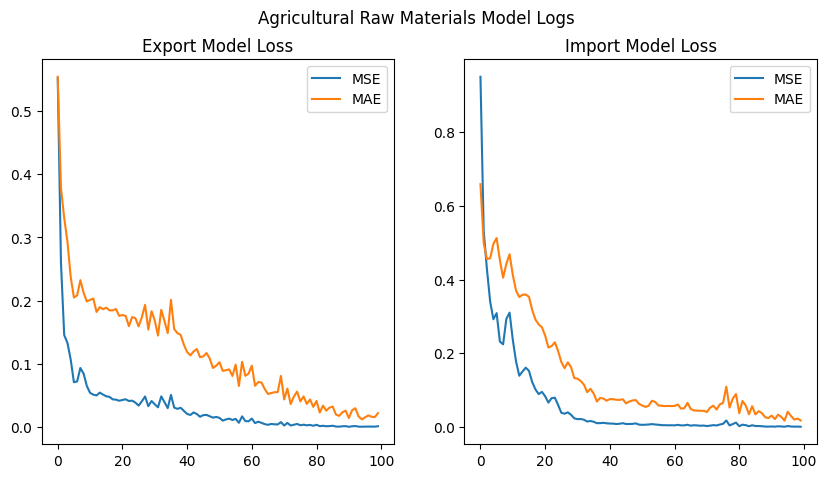

In [13]:
run_ts_model('Agricultural Raw Materials')

................ Training on : Consumer Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8825 - mae: 0.8036
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3086 - mae: 0.4873
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2257 - mae: 0.3944
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1323 - mae: 0.3009
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1306 - mae: 0.2825 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0961 - mae: 0.2775
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0979 - mae: 0.2891
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0796 - mae: 0.2668
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0585 - mae: 0.2321
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0431 - mae: 0.1764
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0552 - mae: 0.1729
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0360

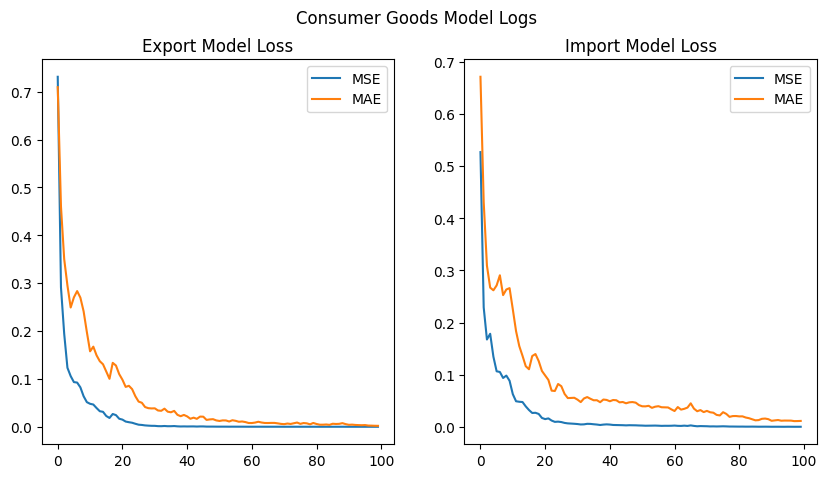

In [14]:
run_ts_model('Consumer Goods')

................ Training on : Transportation ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.2650 - mae: 0.7479
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3806 - mae: 0.8828
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0590 - mae: 0.7968
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7295 - mae: 0.7033
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8659 - mae: 0.7505
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7682 - mae: 0.7229
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6919 - mae: 0.6848
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4551 - mae: 0.5598
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4697 - mae: 0.5576
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6044 - mae: 0.6627
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3923 - mae: 0.5369
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3215 

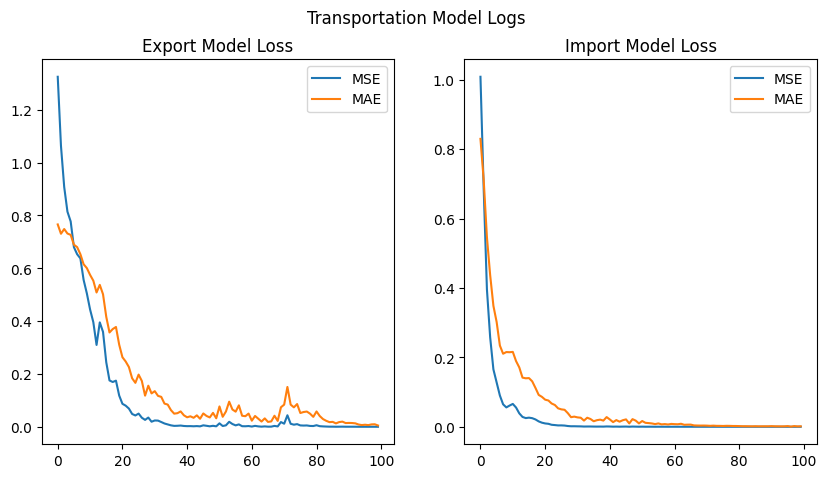

In [15]:
run_ts_model('Transportation')

................ Training on : Food Industry ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.1125 - mae: 0.7703
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3596 - mae: 0.4274
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1627 - mae: 0.3011
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1928 - mae: 0.3708
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1369 - mae: 0.3240
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0955 - mae: 0.2883
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1059 - mae: 0.2632
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1001 - mae: 0.2520
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0628 - mae: 0.1941
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0660 - mae: 0.2191
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0611 - mae: 0.1858
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0651 -

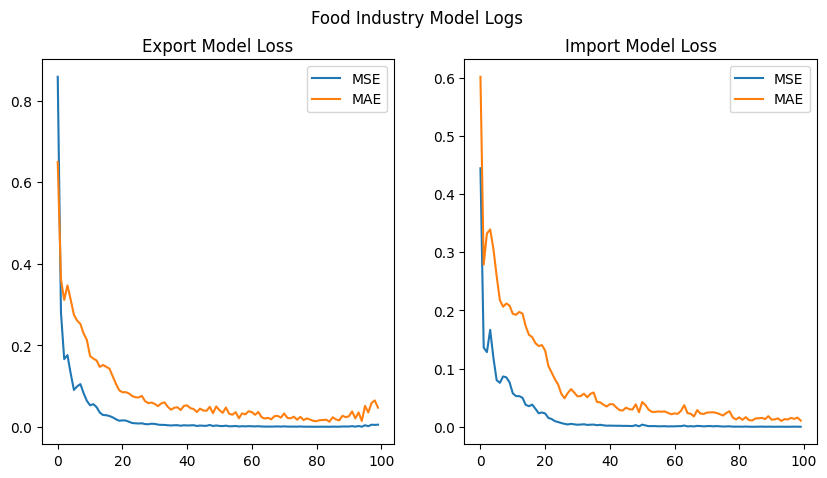

In [16]:
run_ts_model('Food Industry')

................ Training on : Capital Goods ................
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.1675 - mae: 0.8698
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5085 - mae: 0.5437 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3815 - mae: 0.5312
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3322 - mae: 0.4940
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2334 - mae: 0.3960 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2803 - mae: 0.4288
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2657 - mae: 0.4140
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1788 - mae: 0.3371
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2196 - mae: 0.3980
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1978 - mae: 0.3741
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2356 - mae: 0.4147
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2111

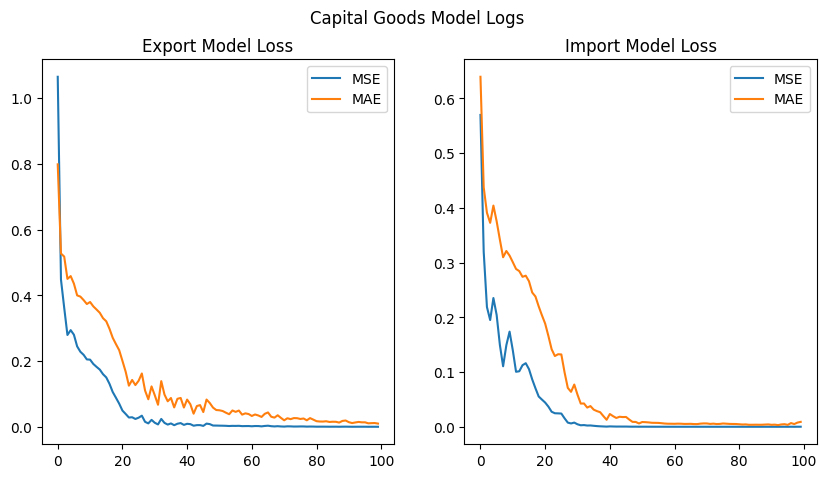

In [17]:
run_ts_model('Capital Goods')

## Inference

In [18]:
industries = [
            'Agricultural Raw Materials',
            'Consumer Goods',
            'Transportation',
            'Food Industry',
            'Capital Goods'
            ]

model_dir = "models/ImpExp/{}"
data_dir = "data/ImpExp/{}"

model_dict = {}

for industry in industries:
    industry_dict = {}
    industry_dict['Imp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Imp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Exp Model'] = tf.keras.models.load_model(
                                                            model_dir.format(f"{industry} Exp.h5"),
                                                            custom_objects={'mse': 'mse'}
                                                            )
    industry_dict['Scaler'] = pickle.load(open(model_dir.format(f"{industry} Scalar.pickle"), 'rb'))

    model_dict[industry] = industry_dict

In [19]:
def predict_ts_on_industry(
                            industry,
                            selective_window=7
                            ):
    industry_dict = model_dict[industry]
    scaler = industry_dict['Scaler']
    imp_model = industry_dict['Imp Model']
    exp_model = industry_dict['Exp Model']

    df = load_industry_data(industry)
    df_tail = df.tail(selective_window)

    x = df_tail.values
    x = x.reshape(1, x.shape[0], x.shape[1])

    p_imp = imp_model.predict(x).squeeze()
    p_imp = np.vstack([p_imp]*selective_window).squeeze()
    p_imp = np.dstack([p_imp]*selective_window).squeeze()
    p_imp = scaler.inverse_transform(p_imp)
    p_imp = p_imp[0][0]

    p_exp = exp_model.predict(x).squeeze()
    p_exp = np.vstack([p_exp]*selective_window).squeeze()
    p_exp = np.dstack([p_exp]*selective_window).squeeze()
    p_exp = scaler.inverse_transform(p_exp)
    p_exp = p_exp[0][0]

    df_tail_inv = scaler.inverse_transform(df_tail)
    imp_data = df_tail_inv[:, 0]
    exp_data = df_tail_inv[:, 1]

    avg_imp = np.mean(imp_data)
    avg_exp = np.mean(exp_data)

    # percentage of change
    p_imp = ((p_imp - avg_imp) / avg_imp) * 100
    p_exp = ((p_exp - avg_exp) / avg_exp) * 100

    return p_imp, p_exp

In [20]:
p_imp, p_exp = predict_ts_on_industry('Agricultural Raw Materials')

print(f"Predicted Export Change : {p_exp:.2f}%")
print(f"Predicted Import Change : {p_imp:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Predicted Export Change : 18.36%
Predicted Import Change : 10.50%
